In [1]:

%load_ext autoreload
%autoreload 2

In [2]:

import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

Current working directory:  c:\Users\thomaswi\OneDrive - SINTEF\Drilling and well\Code\CodeForMaster


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import skew, kurtosis
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_102,
    FILE_PATH_CASE_102b_HFM_T,
    FILE_PATH_CASE_102b_HFM_T_OBS,
    FILE_PATH_CASE_102b_HFM_Z,
    FILE_PATH_DRILLING_REPORT_LABELED_CASE_102,
)
from utils.constants.constants import conversion_factor_for_densities
from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    plot_with_warnings_down_hole_ecd,
    plot_with_warnings_pack_off_sensor_1_2,
    regression_for_asm_data_points

)
from utils.Classes.Classes.PackOffDetectionAlgorithm import PackOffDetectionAlgorithm
sns.set_theme()

In [4]:
# Loading files
sensor_data = pd.read_pickle(FILE_PATH_CASE_102)
# Extracting the dates to consider
tstamp_min = '2020-08-13 16:20:00+00:00'
tstamp_max = '2020-08-15 01:40:00+00:00'
sensor_data = sensor_data.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data = sensor_data.iloc[1:] 
hfm_data_t = pd.read_pickle(FILE_PATH_CASE_102b_HFM_T)
hfm_data_t_obs = pd.read_pickle(FILE_PATH_CASE_102b_HFM_T_OBS)
hfm_data_z = pd.read_pickle(FILE_PATH_CASE_102b_HFM_Z)
hfm_data_t.index = sensor_data.index
hfm_data_t_obs.index = sensor_data.index


In [5]:
# Threshold based on 100 us gpm value to ensure active drilling
threshold_value_flow = 0.0
df_sensor, df_simulated = get_active_drilling_data(df = sensor_data, sim_df=hfm_data_t_obs, include_rop_zeros=True)
# df_sensor = df_sensor[(df_sensor["MUD_FLOW_IN"]) > threshold_value_flow]
df_simulated = df_simulated.loc[df_sensor.index]
df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities
diff_flow = df_sensor["MUD_FLOW_IN"].diff()
diff_rpm = df_sensor["RPM_SURF"].diff()

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_25788\655810903.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor["DH_PRESS_ECD"] = df_sensor["DH_PRESS_ECD"] / conversion_factor_for_densities


In [6]:
print(len(df_sensor.values))
print(len(df_simulated))
print(diff_flow.max())
print(diff_rpm.max())
print(diff_flow.min())

5942
5942
0.01413402
6.3356752799999985
-0.02678198


In [ ]:
# Used idx 735 and 5203 in the thesis

transients_idx = [4800]

In [8]:
plt.rcParams['text.usetex'] = True
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme()
transients = []
ecd_1_segments = []
ecd_2_segments = []
ecd_1_segments_sim = []
ecd_2_segments_sim = []
window_size = 20
for index in transients_idx:
    transients.append([df_sensor.index[index], index])
    ecd_1_segments.append(df_sensor["ASMECD1-T"].iloc[index - window_size:index + window_size].values)
    ecd_2_segments.append(df_sensor["ASMECD2-T"].iloc[index - window_size:index + window_size].values)
    ecd_1_segments_sim.append(df_simulated["ecdAtPos2"].iloc[index - window_size:index + window_size].values)
    ecd_2_segments_sim.append(df_simulated["ecdAtPos3"].iloc[index - window_size:index + window_size].values)

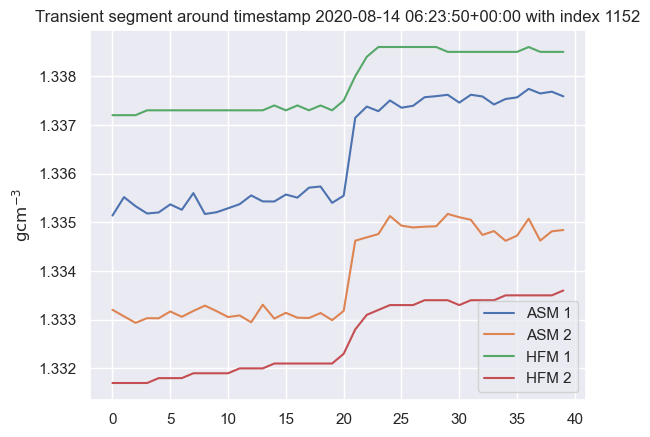

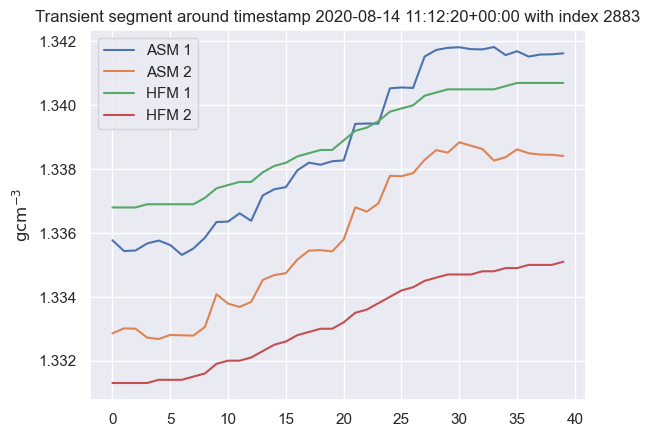

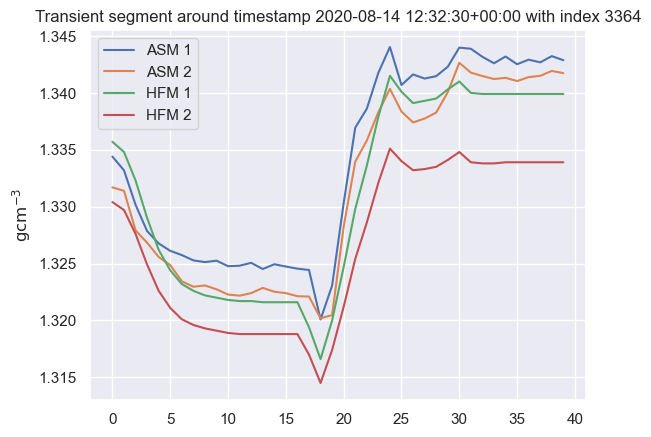

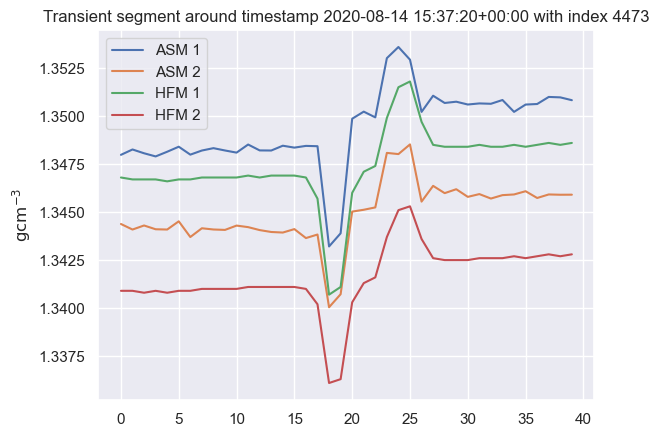

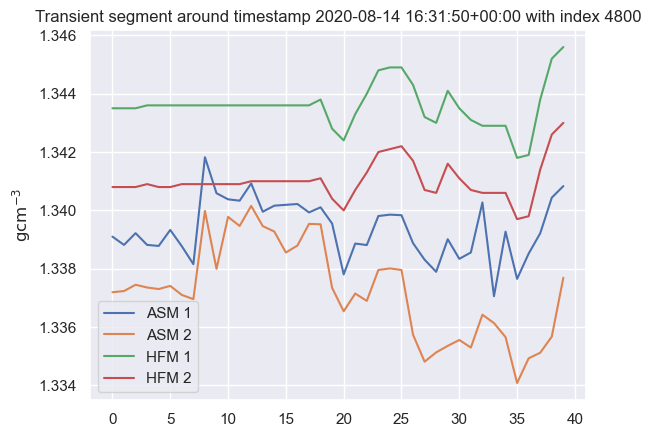

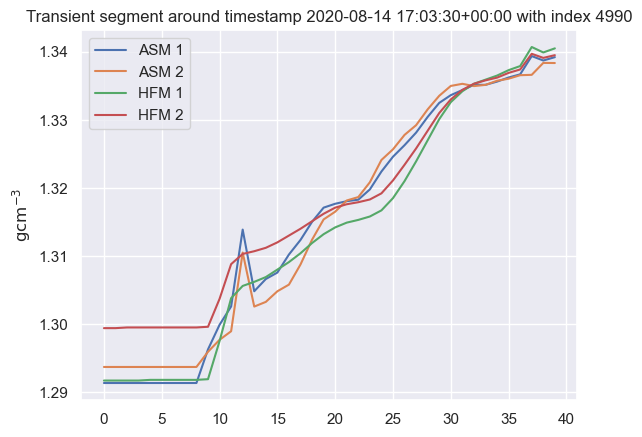

In [9]:
for segment_ecd_1, segment_ecd_2, segment_ecd_1_sim, segment_ecd_2_sim, transient in zip(ecd_1_segments, ecd_2_segments, ecd_1_segments_sim, ecd_2_segments_sim, transients):
    plt.title(f"Transient segment around timestamp {transient[0]} with index {transient[1]}")
    plt.plot(segment_ecd_1, label = "ASM 1")
    plt.plot(segment_ecd_2, label = "ASM 2")
    plt.plot(segment_ecd_1_sim, label = "HFM 1")
    plt.plot(segment_ecd_2_sim, label = "HFM 2")
    plt.ylabel(r'$\text{gcm}^{-3}$')
    plt.legend()
    plt.show()

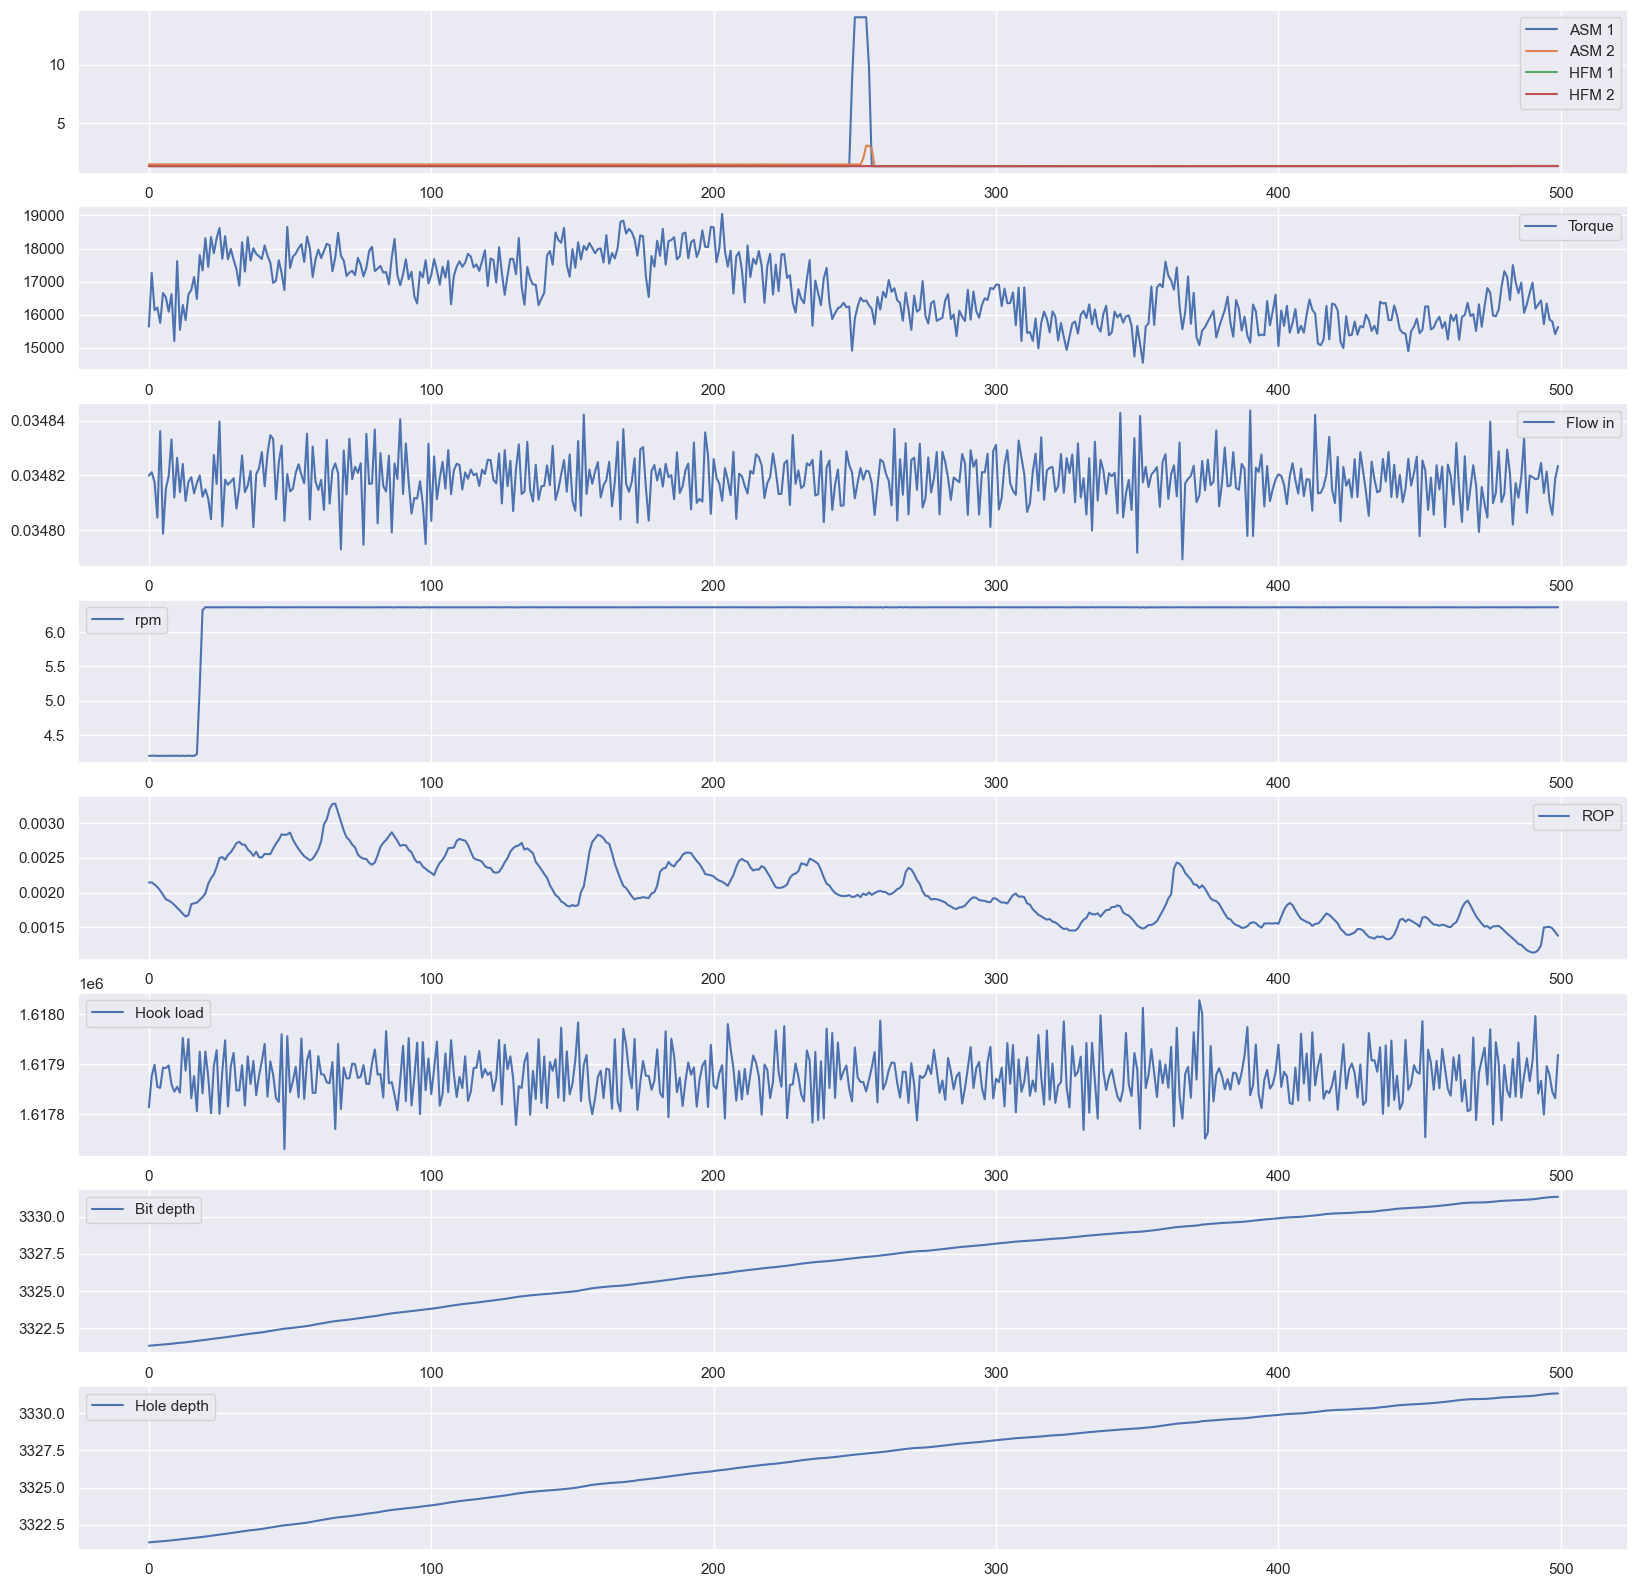

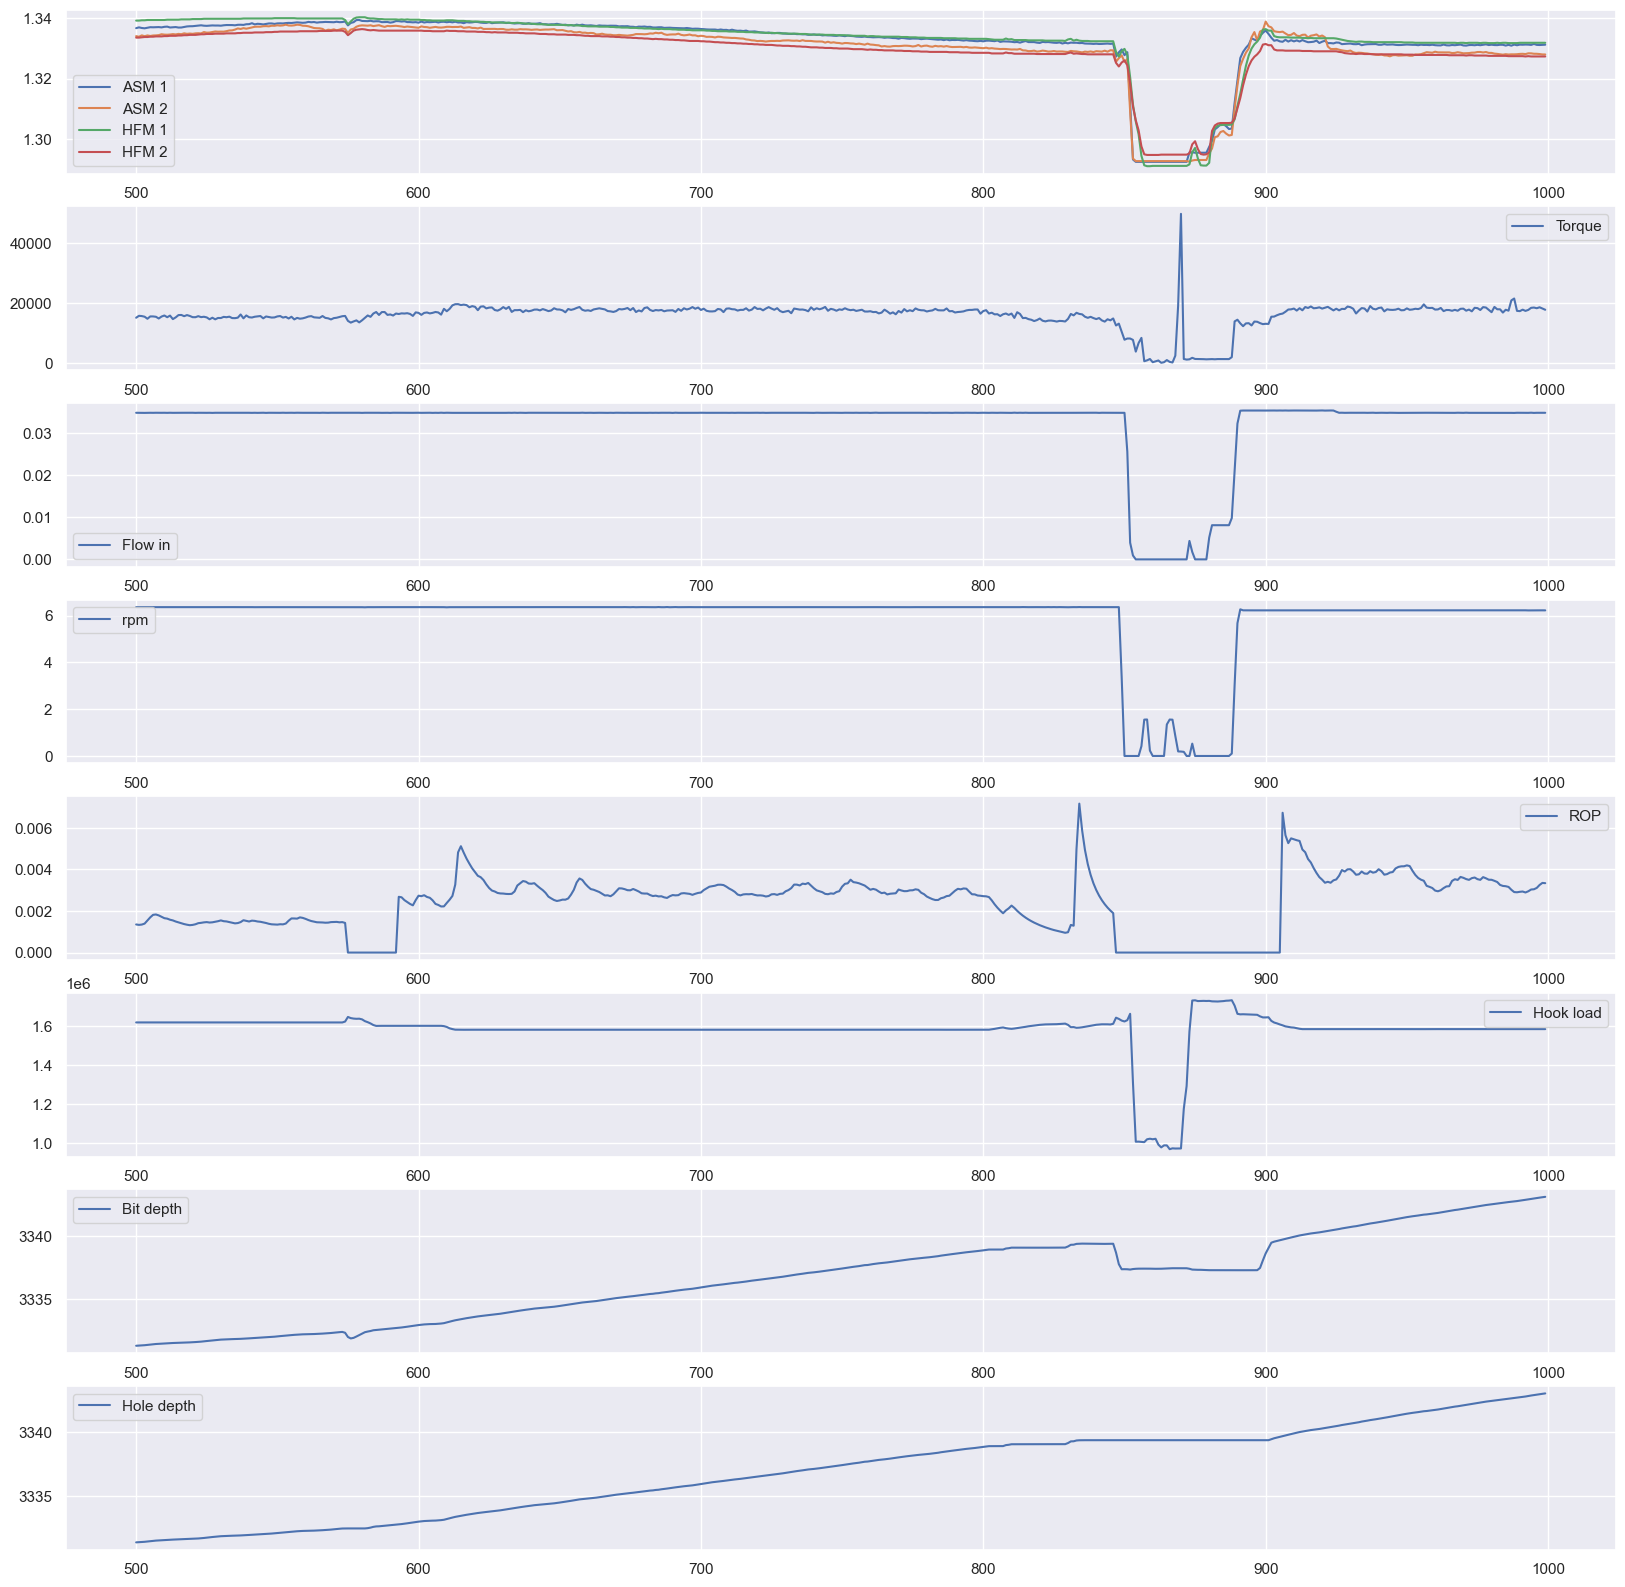

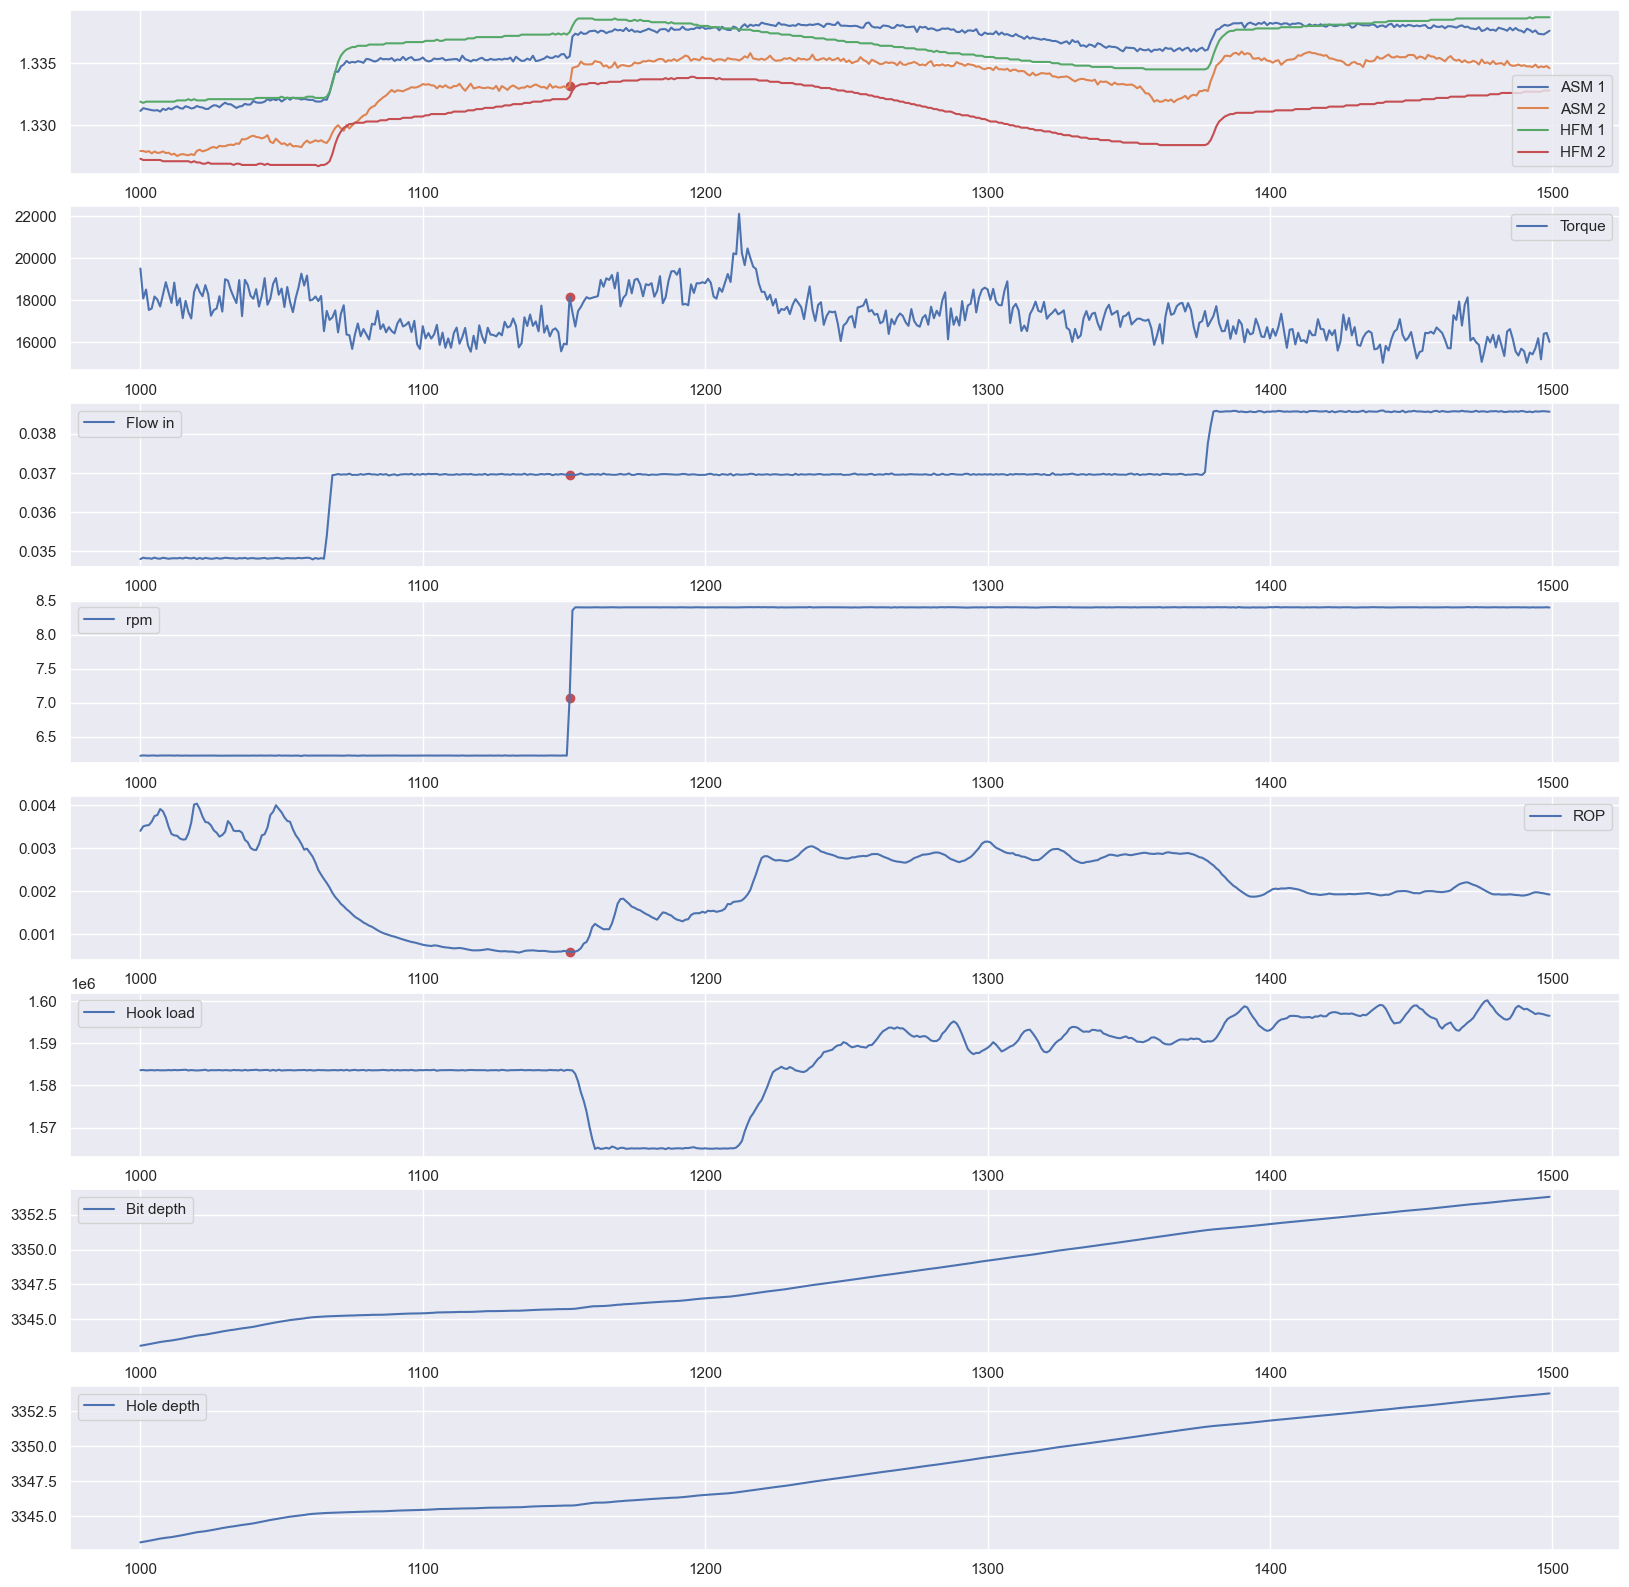

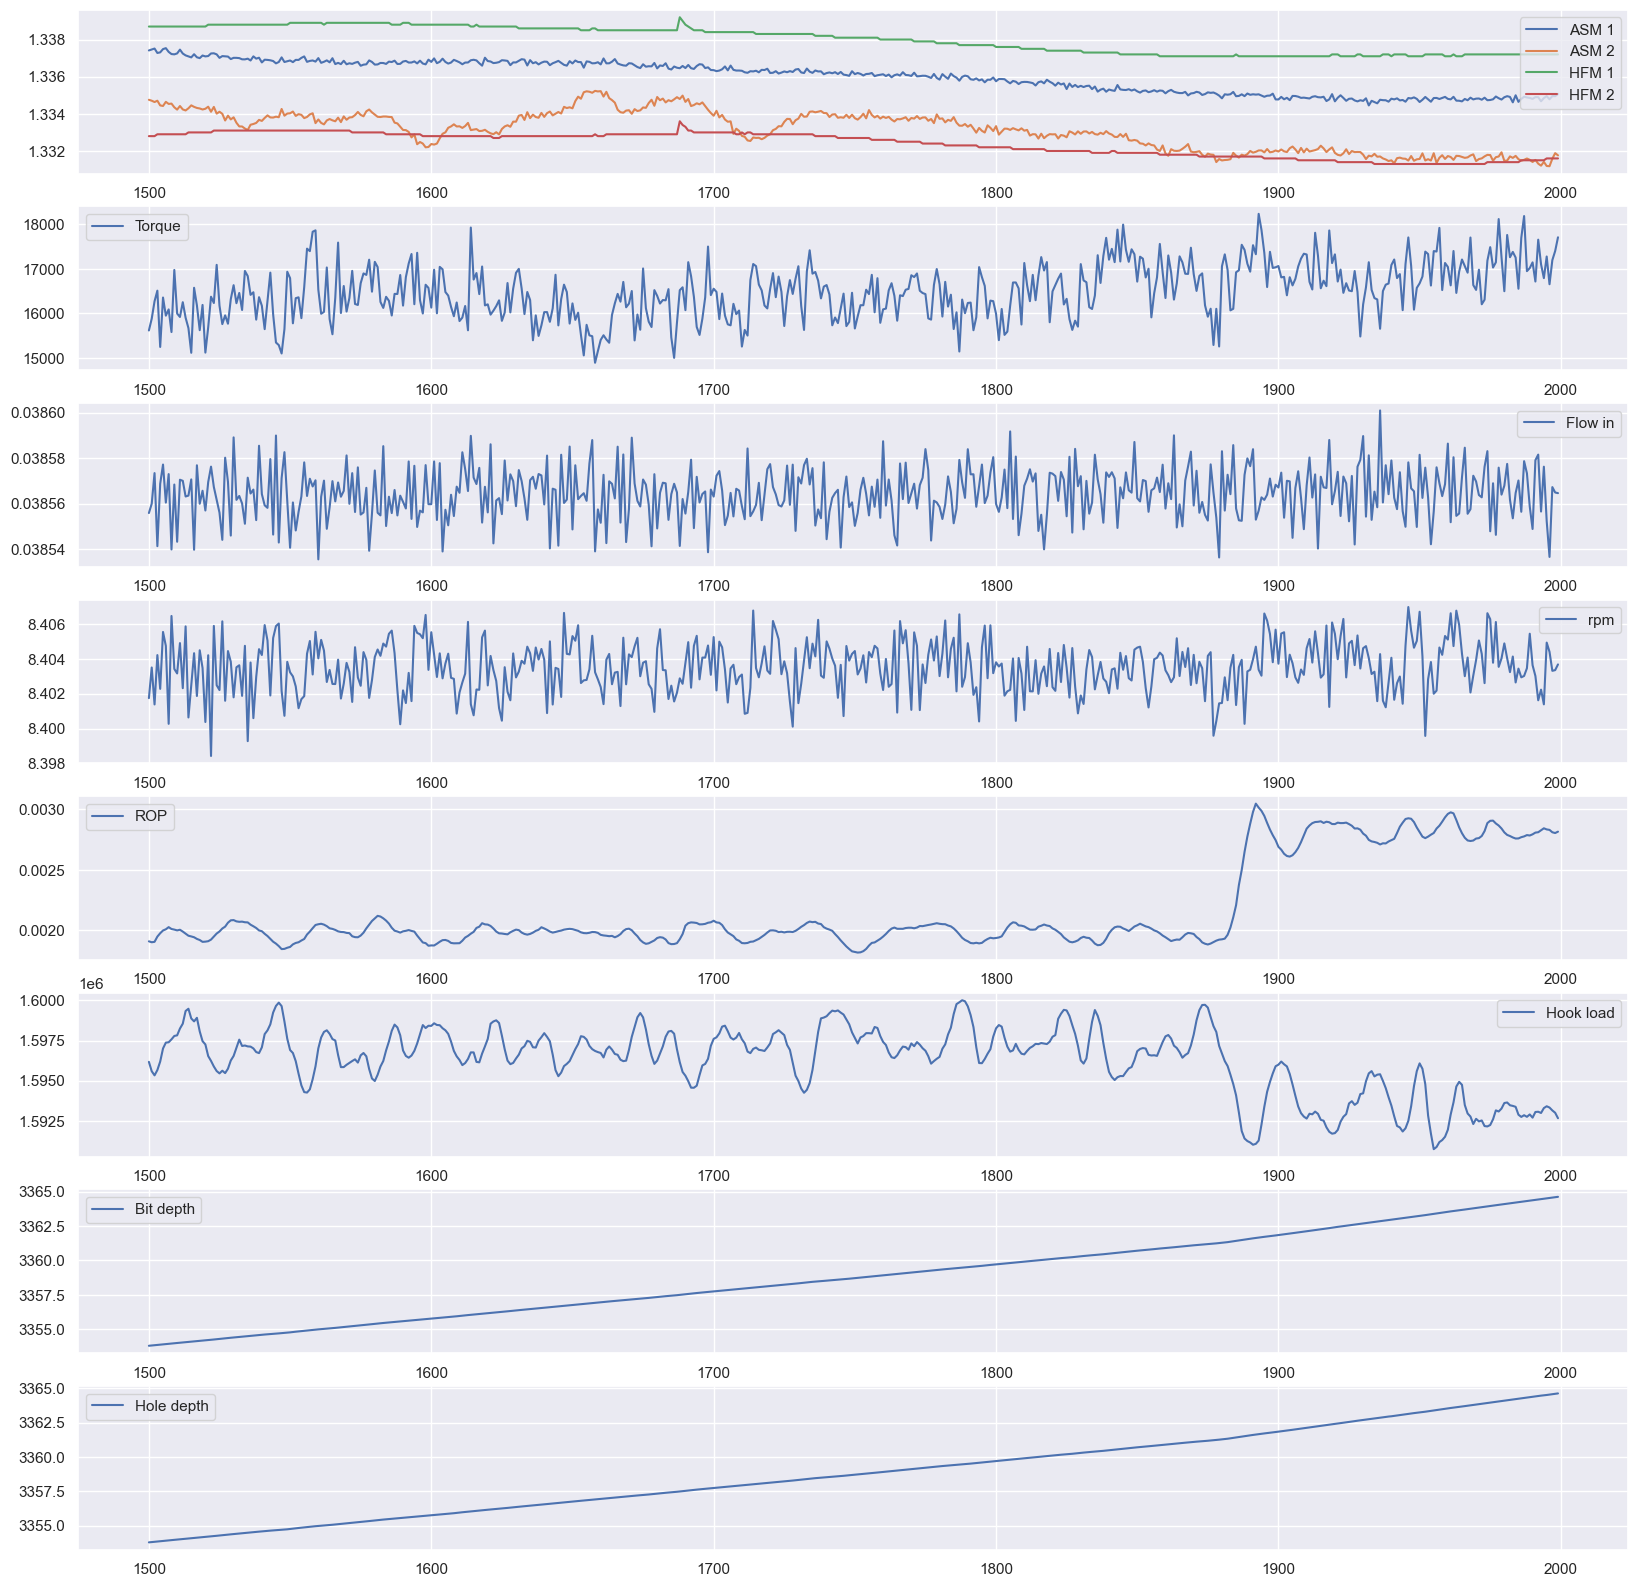

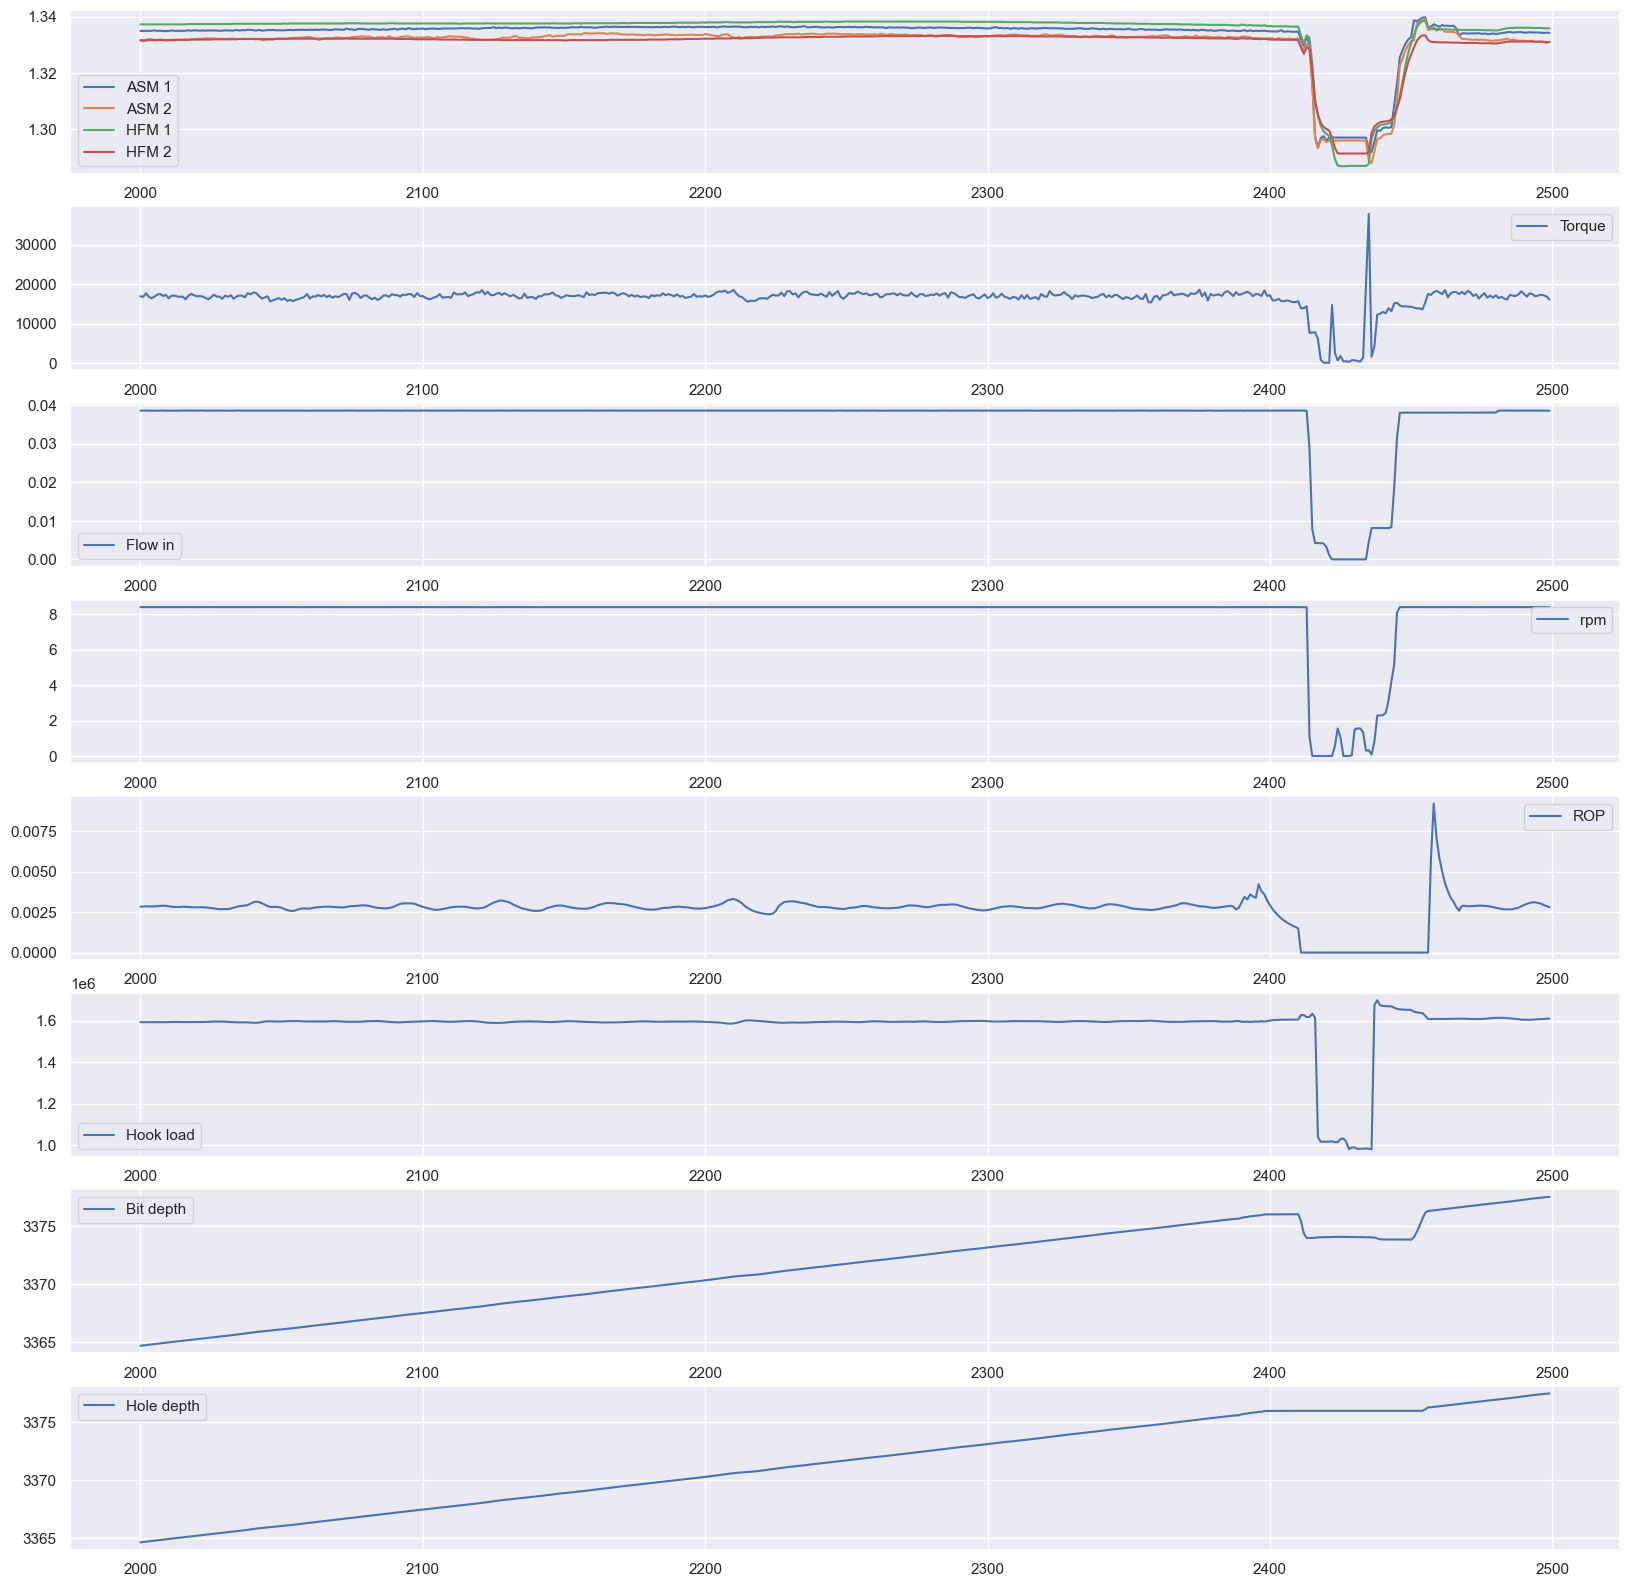

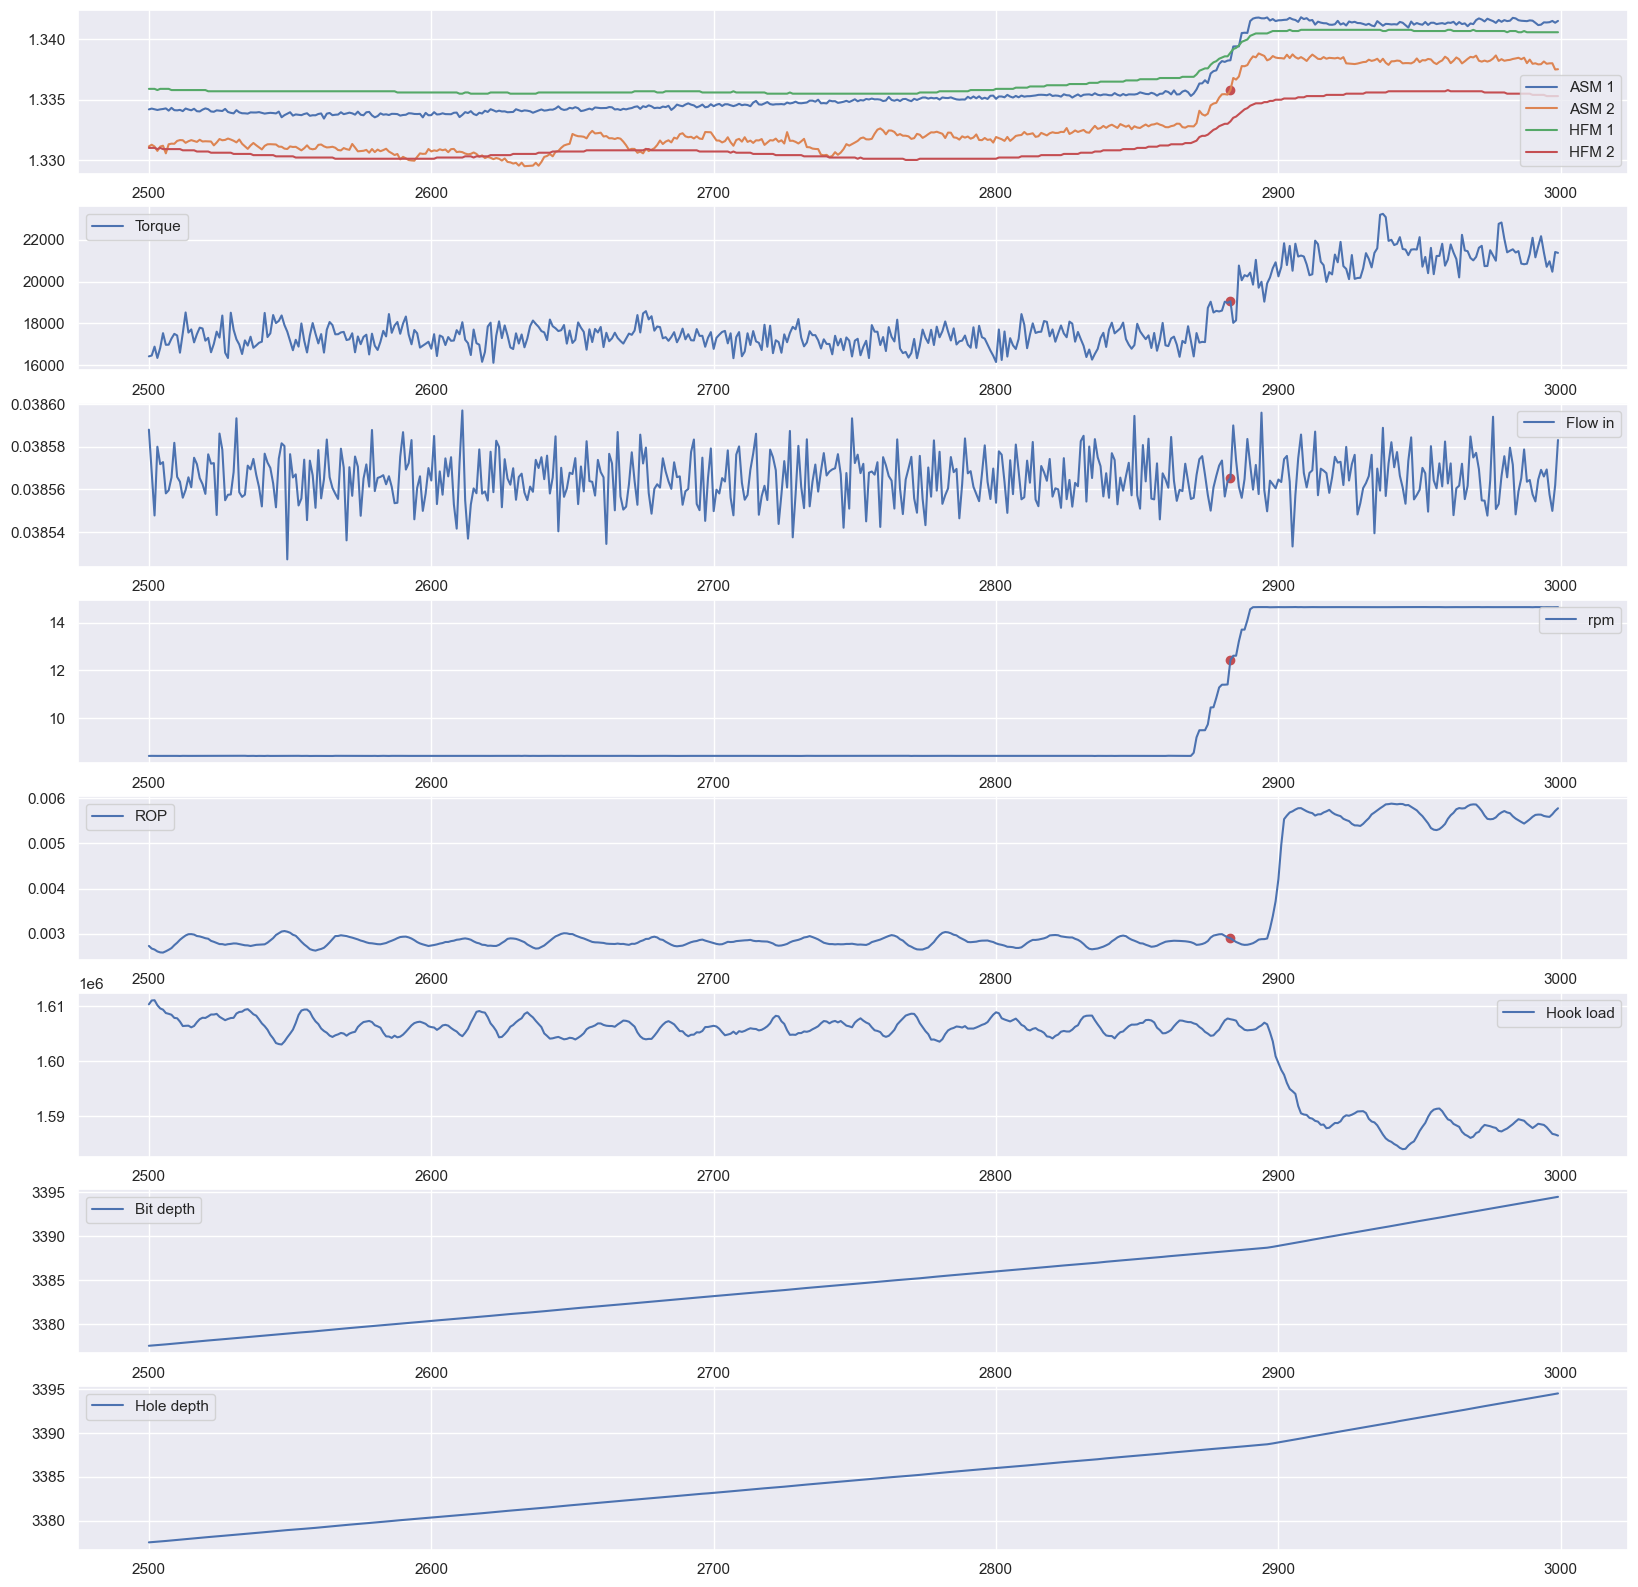

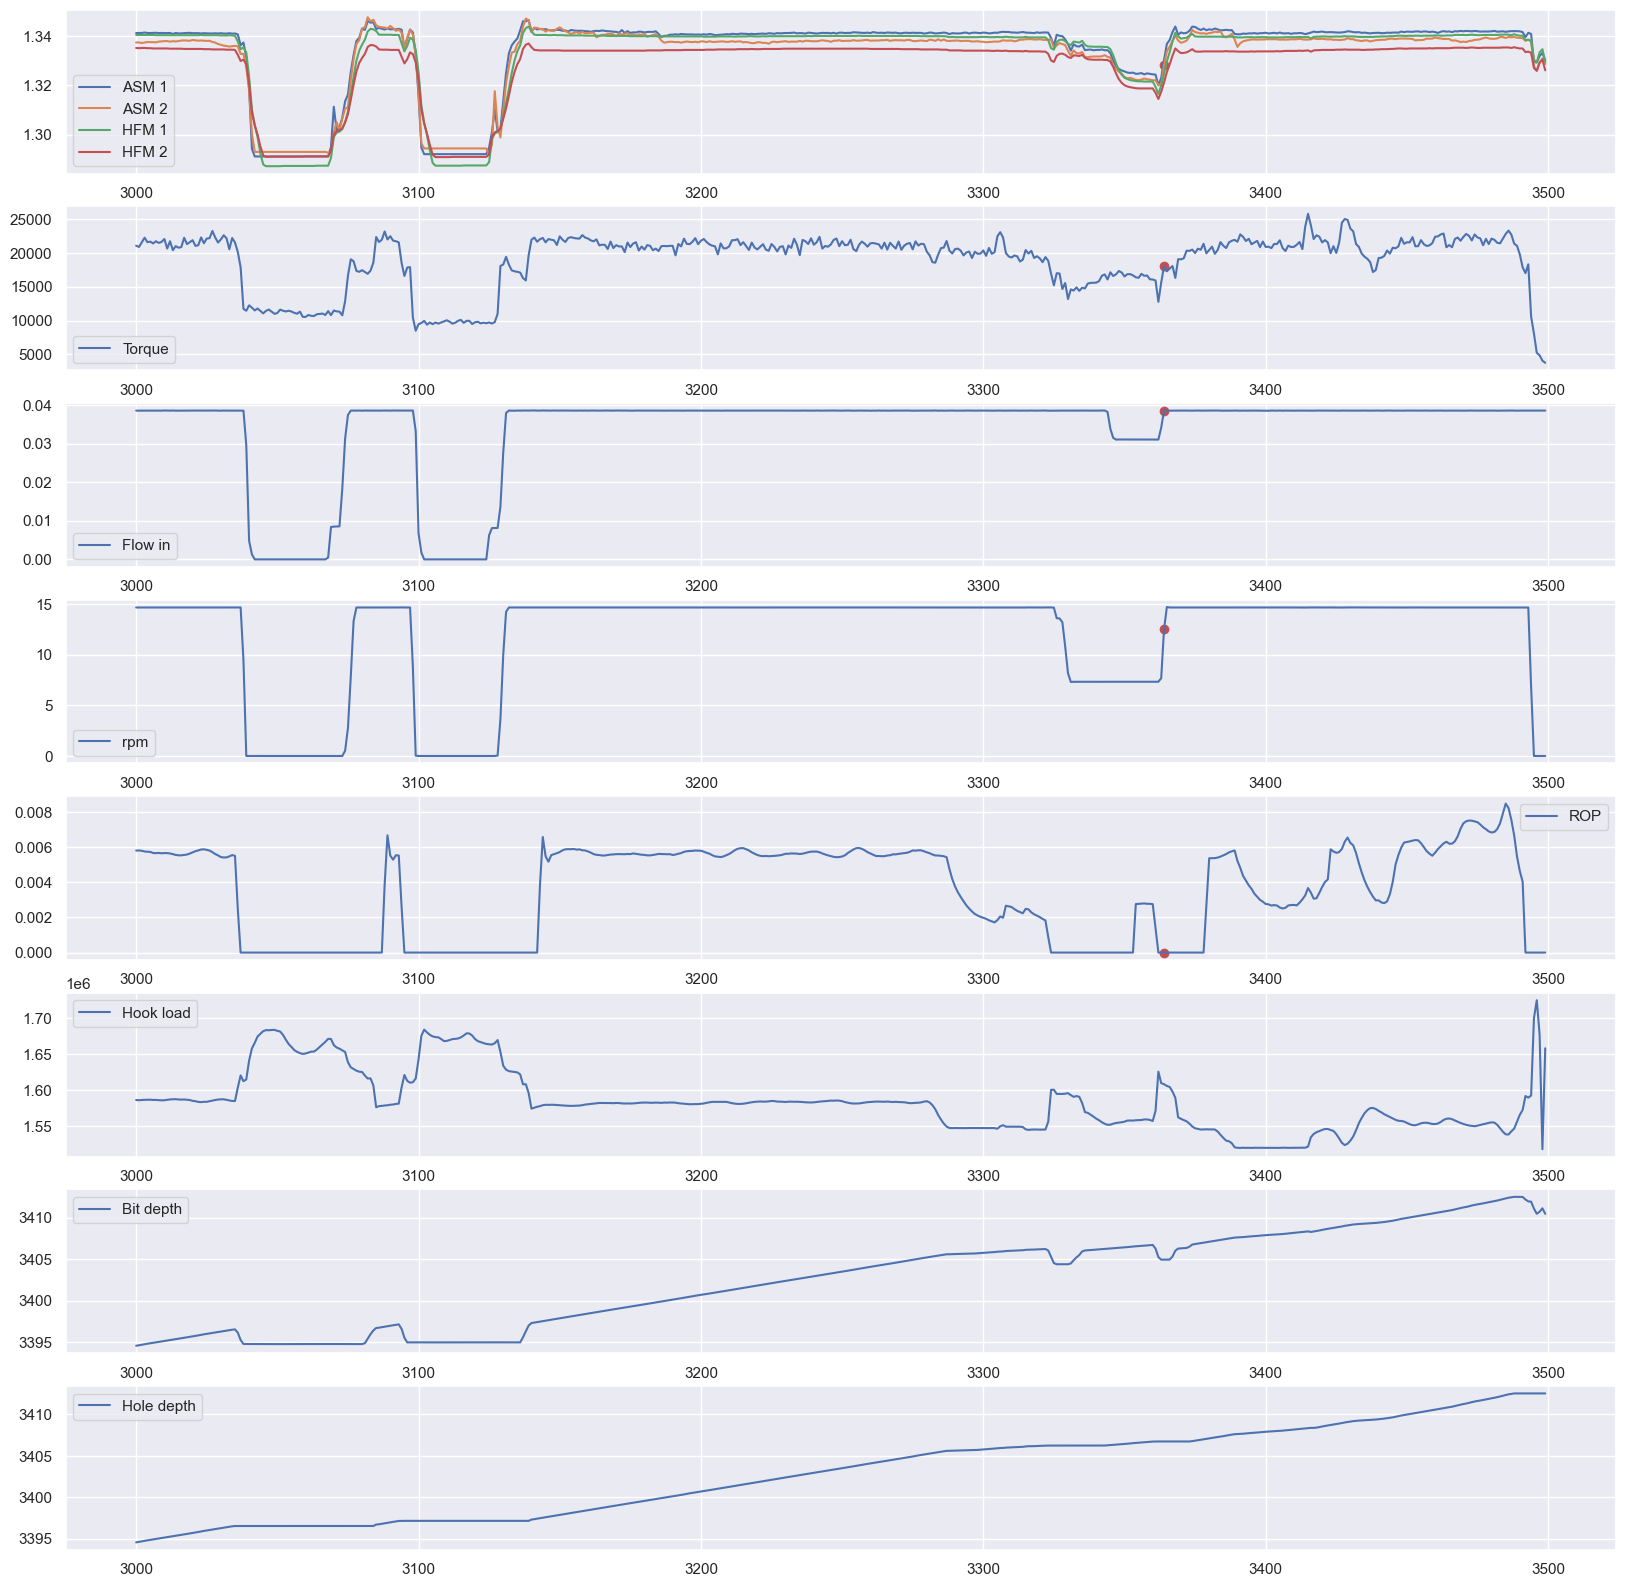

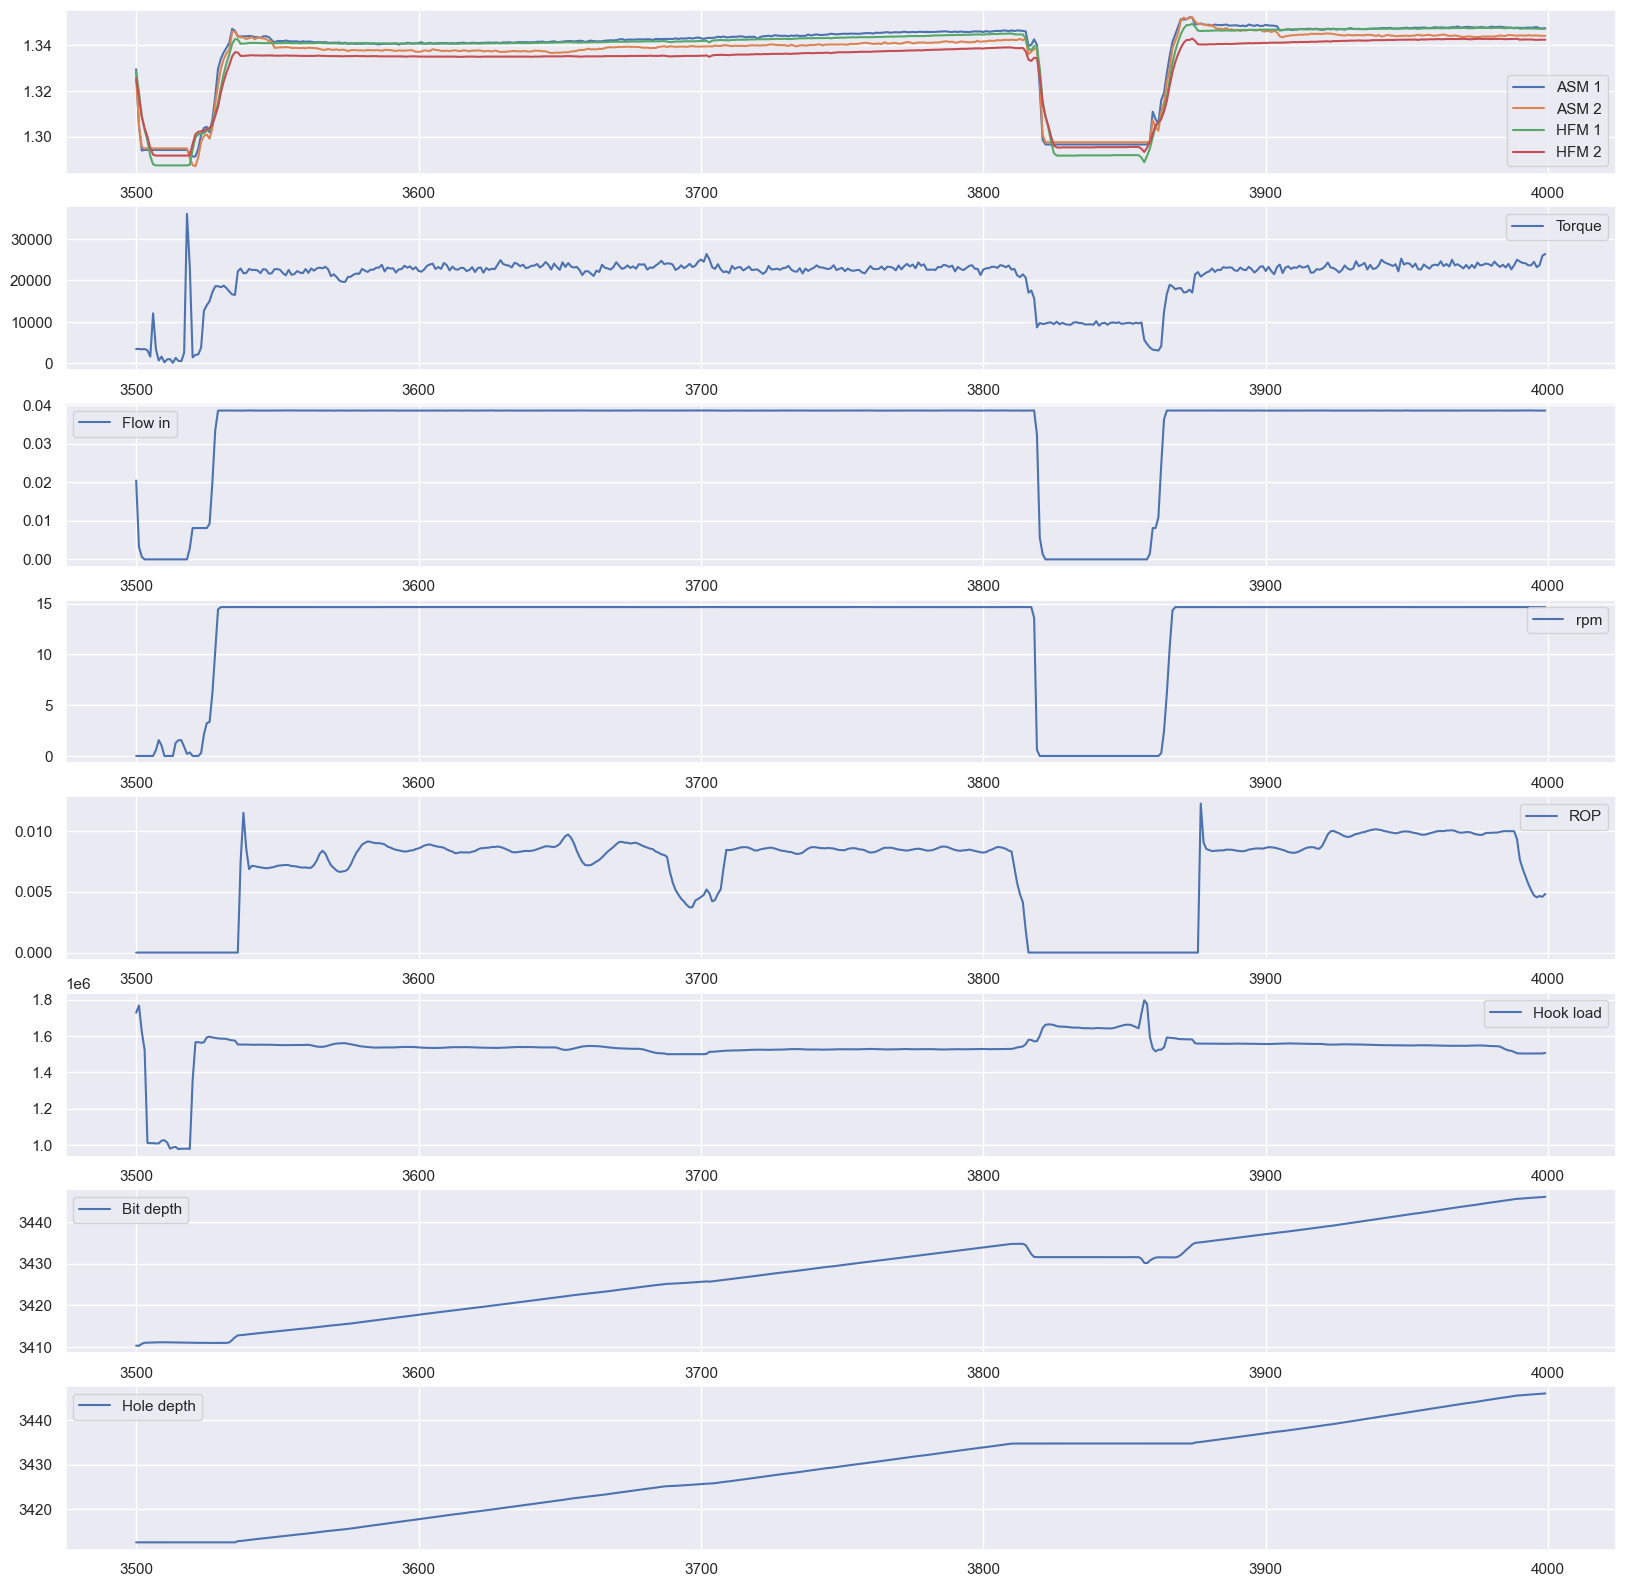

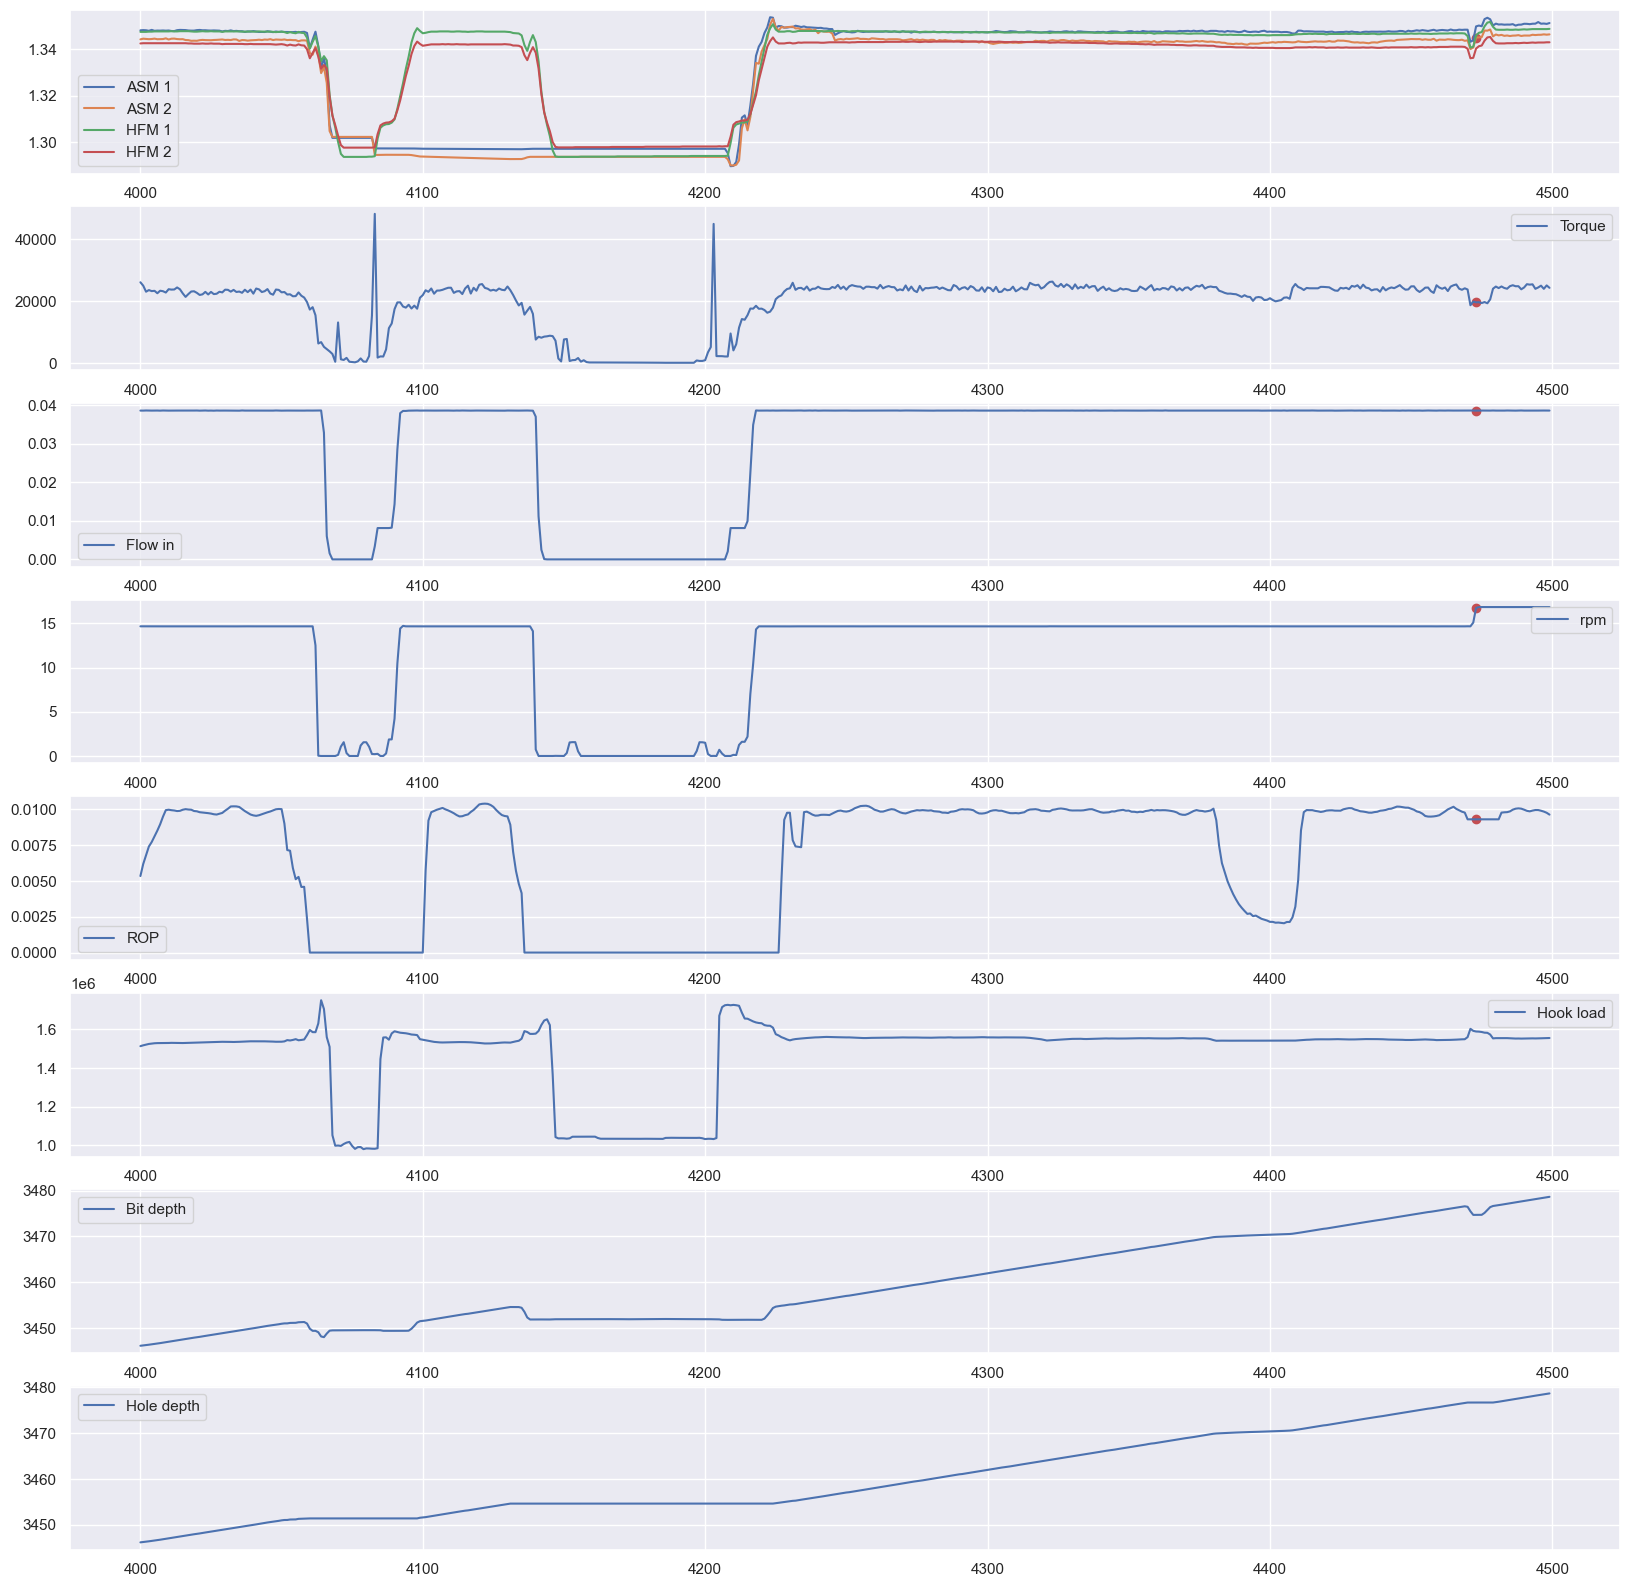

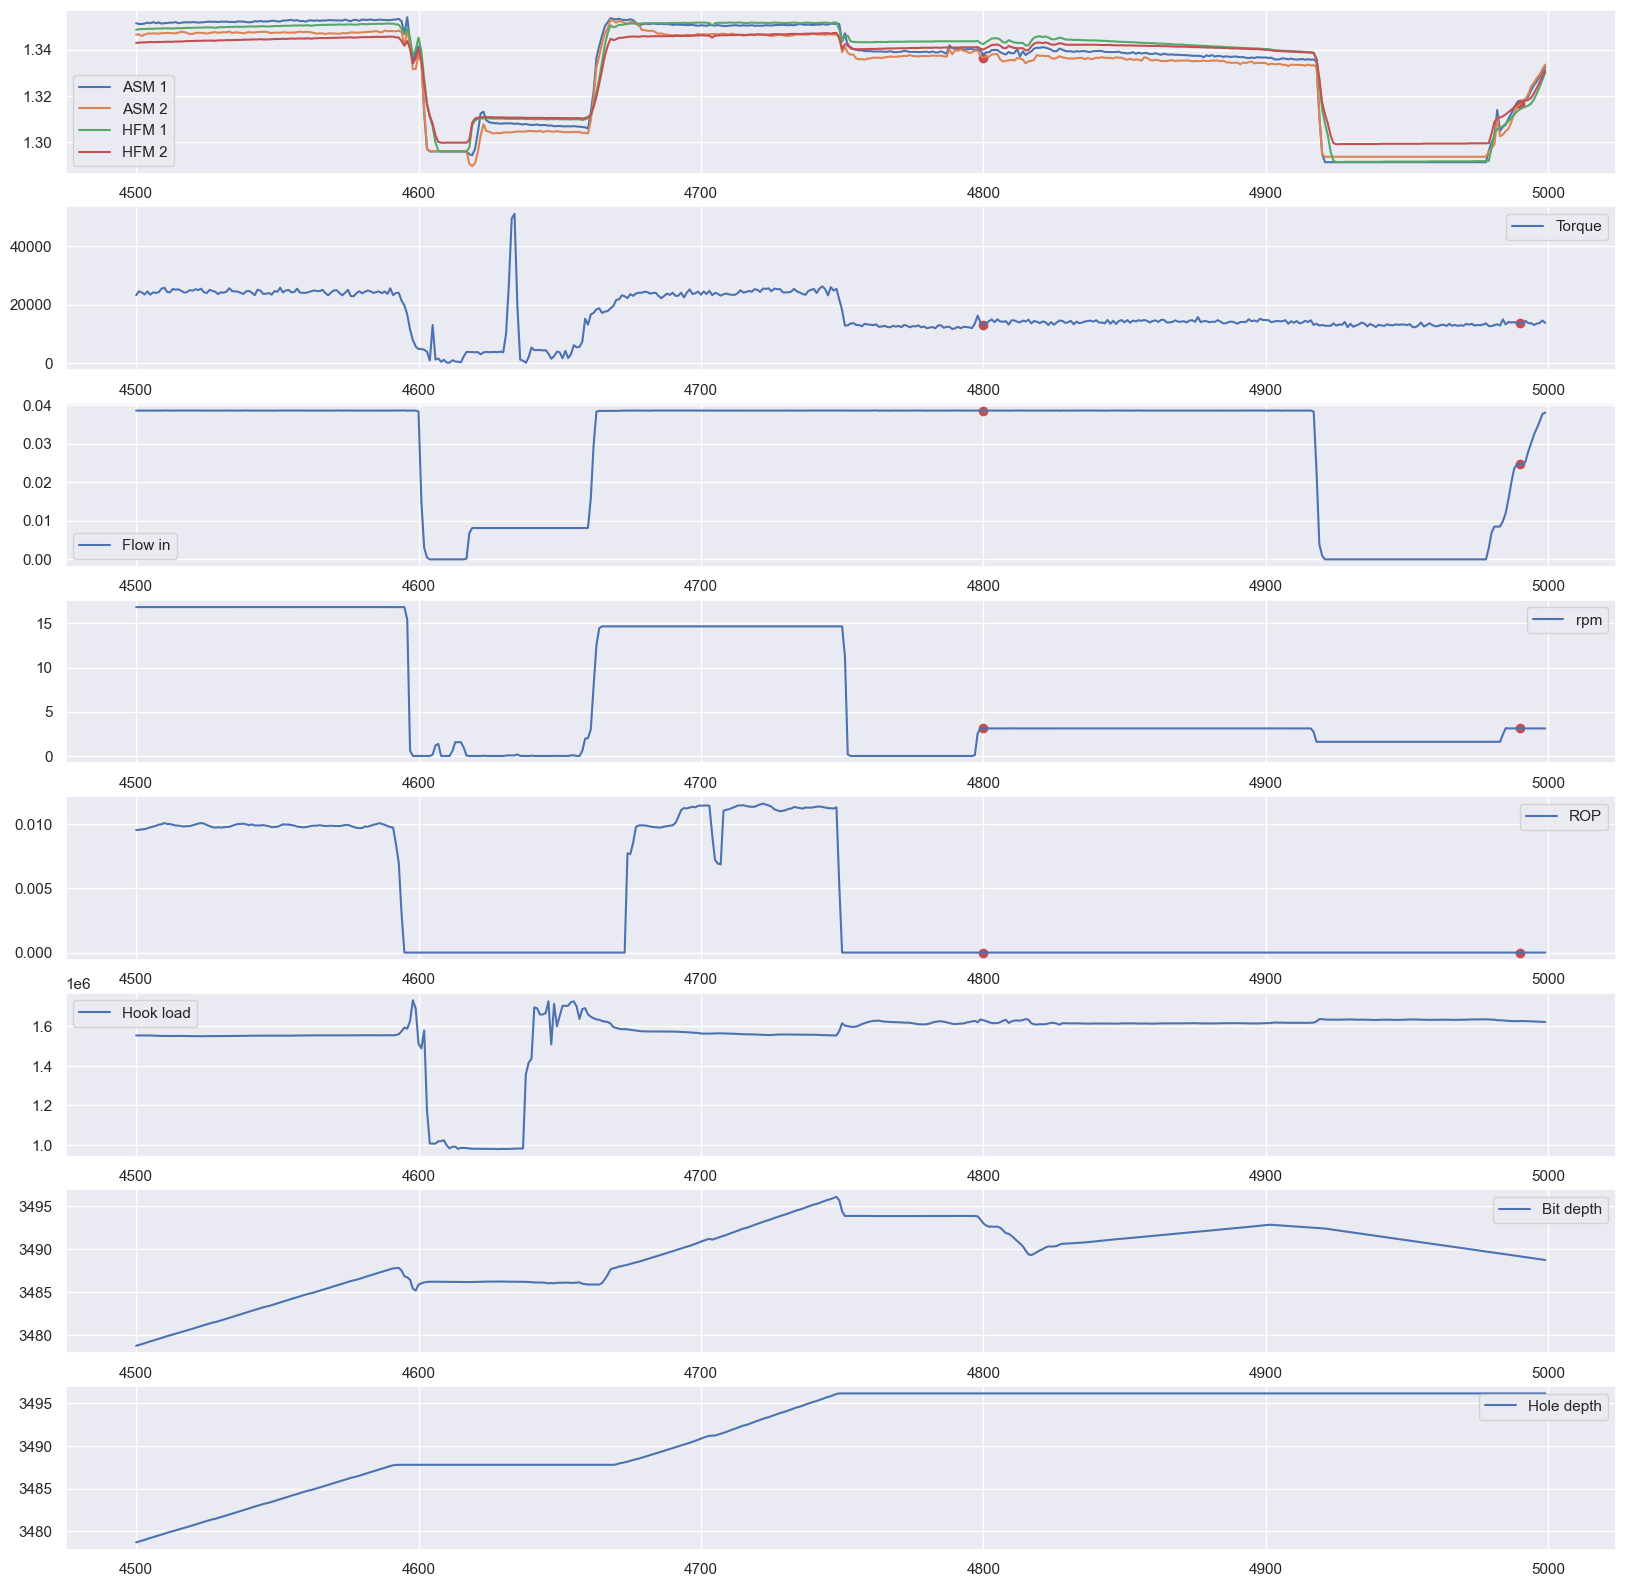

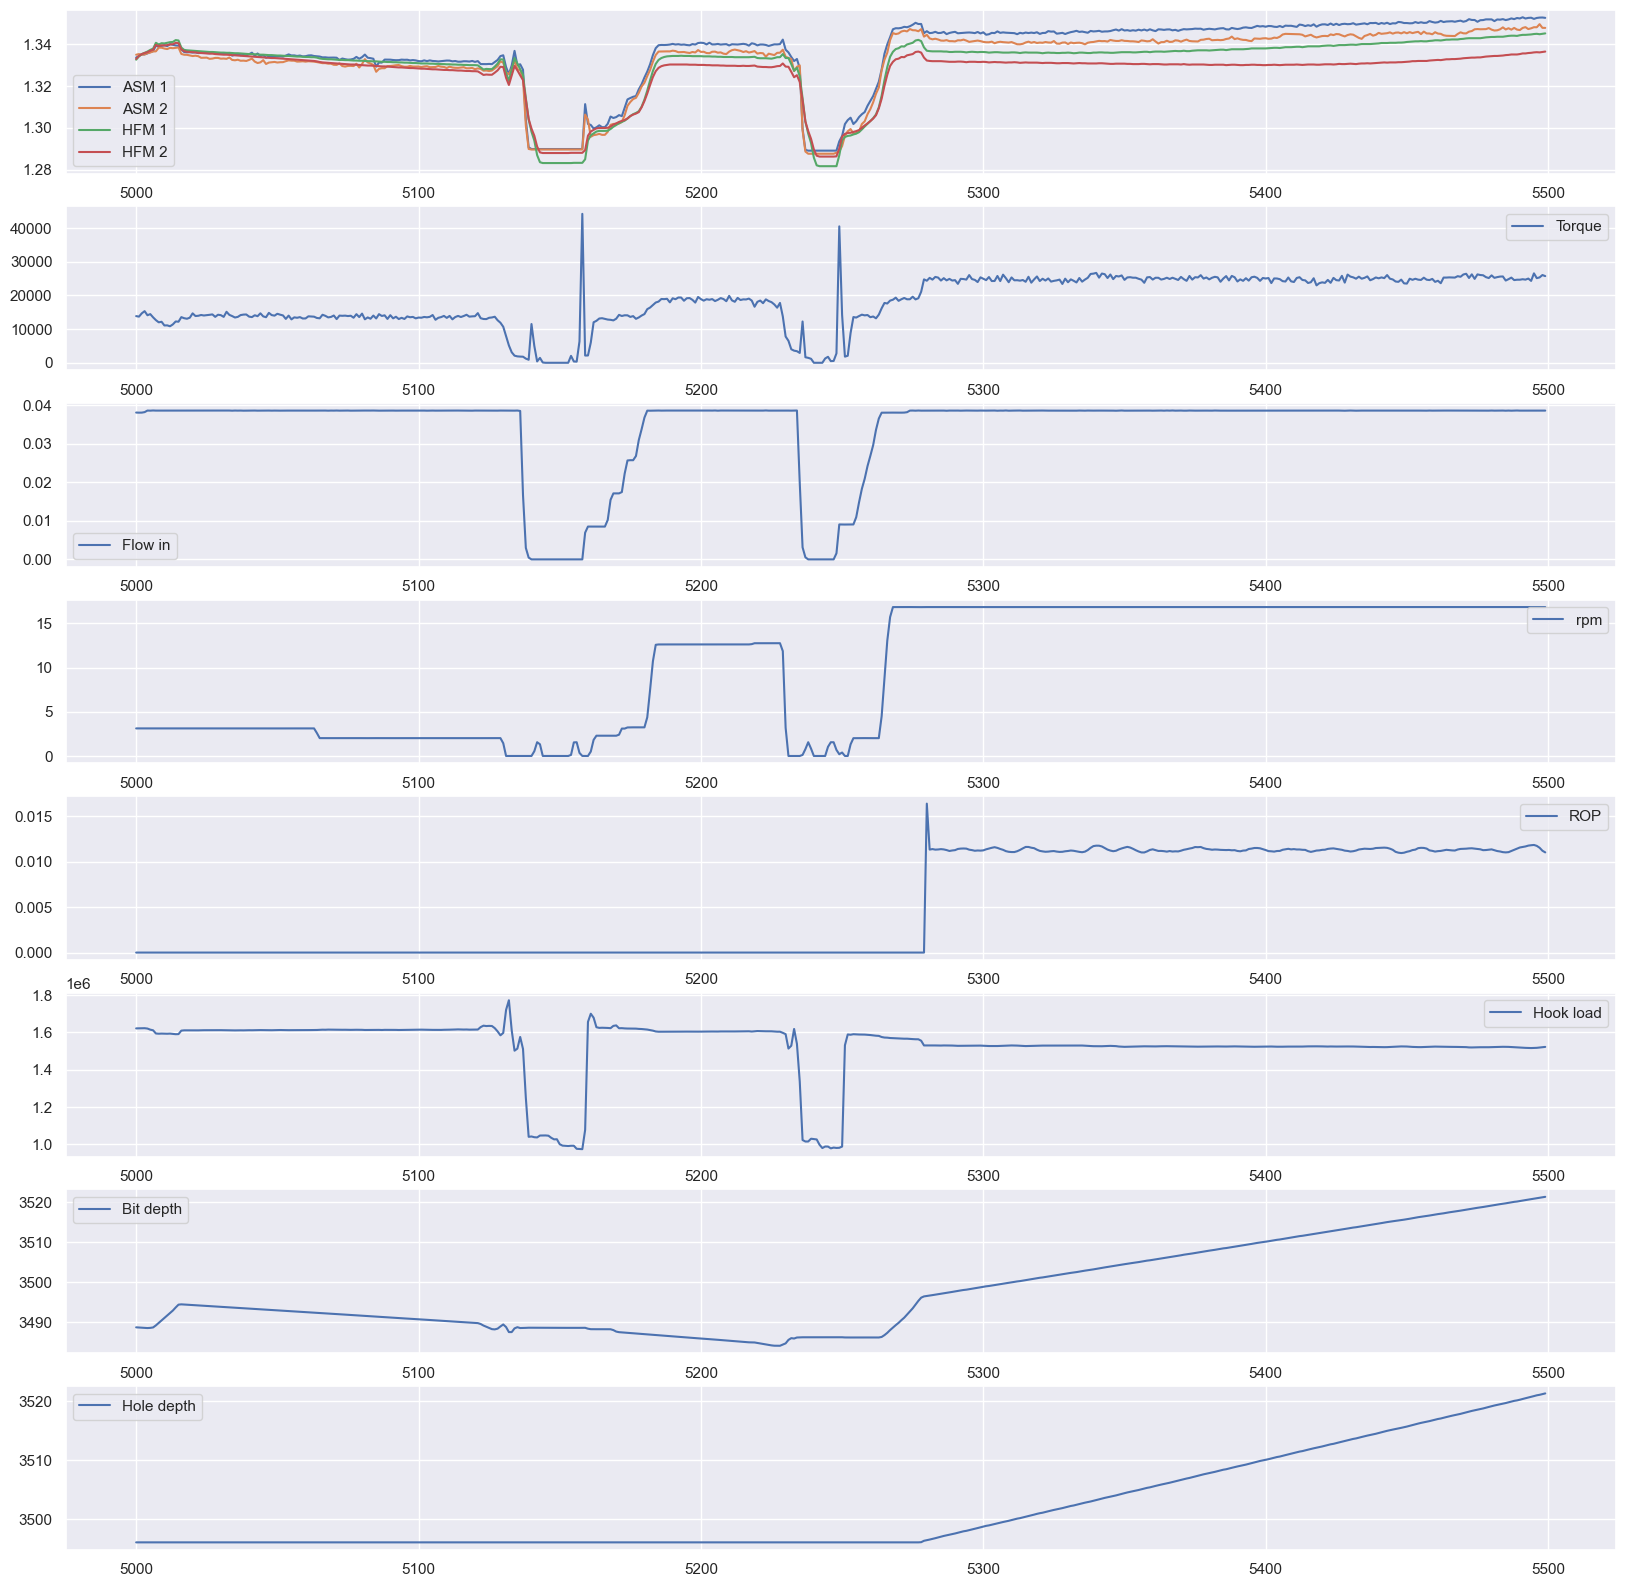

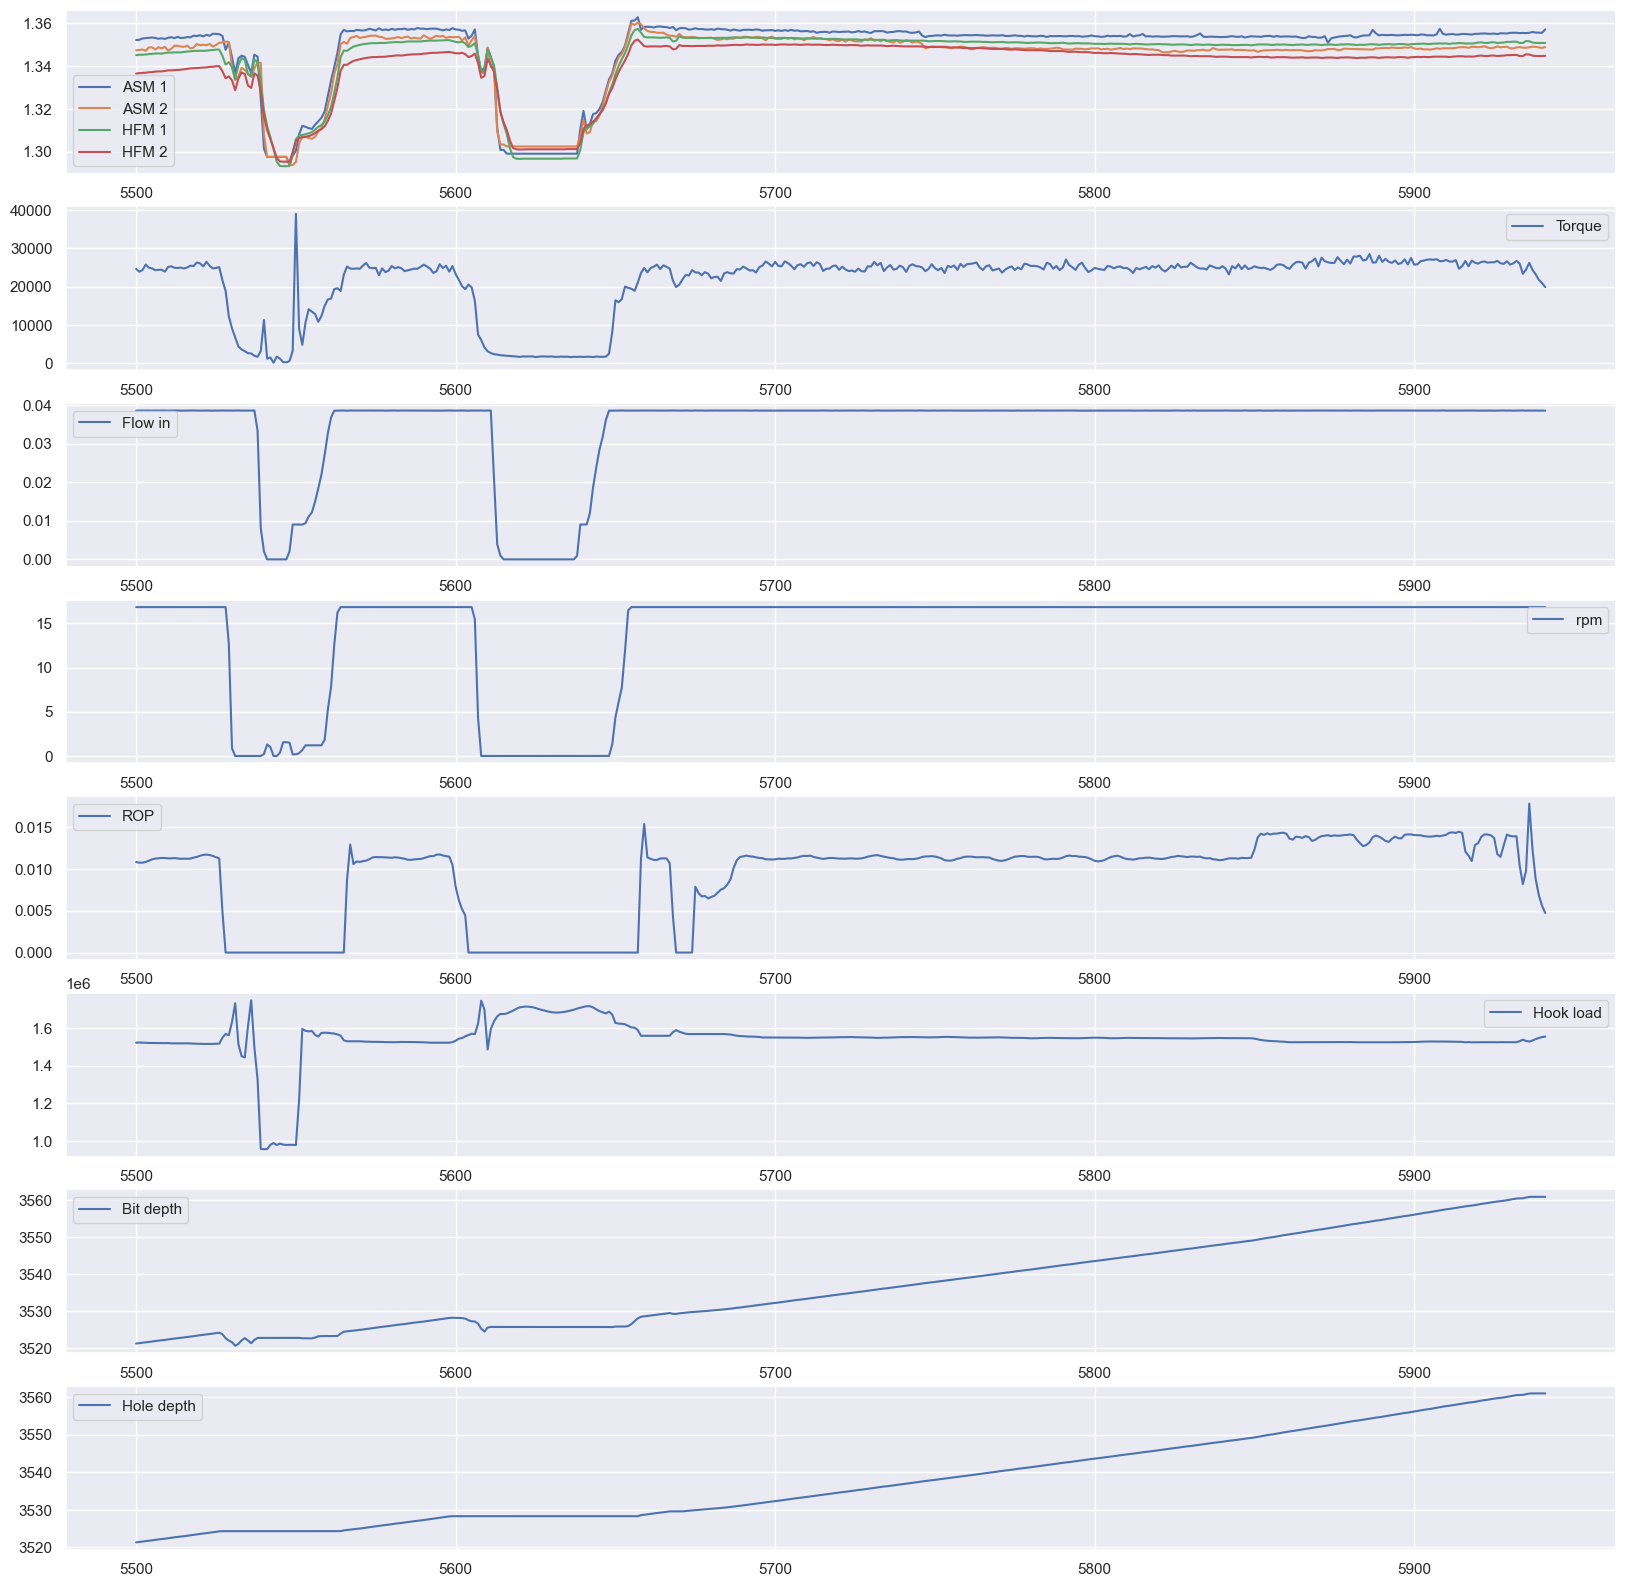

In [10]:
plot_with_warnings_pack_off_sensor_1_2(df_input=df_sensor, df_sim = df_simulated, warnings = transients,chunk_size=500)